In [11]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf
tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(True)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6715589385263371665
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11280059597
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 15443240146159924934
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:88:00.0, compute capability: 3.7"
]


In [12]:

from glob import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import os
import platform

mpl.rc('font', size=14)

In [13]:
import pickle 

with open('host_flux.data', 'rb') as filehandle:
    host_flux = pickle.load(filehandle)

In [14]:
with open('snia_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    snia_flux = pickle.load(filehandle)

In [15]:
with open('snib_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    snib_flux = pickle.load(filehandle)

In [16]:
with open('snibc_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    snibc_flux = pickle.load(filehandle)

In [17]:
with open('snic_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    snic_flux = pickle.load(filehandle)

In [18]:
with open('sniilp_flux .data', 'rb') as filehandle:
    # read the data as binary data stream
    sniilp_flux = pickle.load(filehandle)

In [19]:
with open('sniin_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    sniin_flux = pickle.load(filehandle)

In [22]:
with open('sniip_flux .data', 'rb') as filehandle:
    # read the data as binary data stream
    sniip_flux = pickle.load(filehandle)

In [23]:
nhost, nbins  = host_flux.shape
nsnia, nbins  = snia_flux.shape
nsnib, nbins  = snib_flux.shape
nsnibc, nbins = snibc_flux.shape
nsnic, nbins  = snic_flux.shape
nsniin, nbins = sniin_flux.shape
nsniilp, nbins = sniilp_flux.shape
nsniip, nbins = sniip_flux.shape
nhost, nsnia, nsnib, nsnibc, nsnic, nsniin, nsniilp, nsniip, nbins

(9969, 9964, 9958, 9971, 8269, 9949, 9948, 9962, 150)

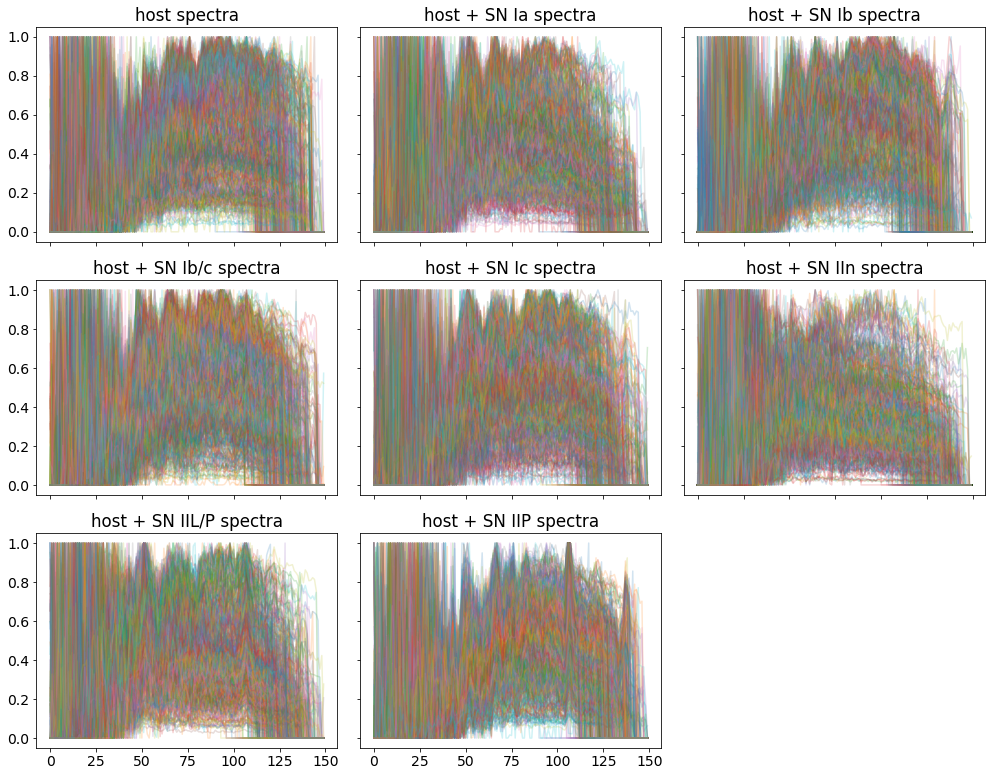

In [24]:
# PLOT
fig, axes = plt.subplots(3,3, figsize=(14,11), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(0,500):
    
    ax = axes[0]
    ax.plot(host_flux[i], alpha=0.2)

    ax = axes[1]
    ax.plot(snia_flux[i], alpha=0.2)
    
    ax = axes[2]
    ax.plot(snib_flux[i], alpha=0.2)
    
    ax = axes[3]
    ax.plot(snibc_flux[i], alpha=0.2)
    
    ax = axes[4]
    ax.plot(snic_flux[i], alpha=0.2)
    
    ax = axes[5]
    ax.plot(sniin_flux[i], alpha=0.2)

    ax = axes[6]
    ax.plot(sniilp_flux[i], alpha=0.2)
    
    ax = axes[7]
    ax.plot(sniip_flux[i], alpha=0.2)
    
axes[0].set_title('host spectra')
axes[1].set_title('host + SN Ia spectra')
axes[2].set_title('host + SN Ib spectra')
axes[3].set_title('host + SN Ib/c spectra')
axes[4].set_title('host + SN Ic spectra')
axes[5].set_title('host + SN IIn spectra')
axes[6].set_title('host + SN IIL/P spectra')
axes[7].set_title('host + SN IIP spectra')

axes[8].axis('off')

fig.tight_layout()


x = np.concatenate([host_flux, 
                    snia_flux,
                    snib_flux,
                    snibc_flux,
                    snic_flux,
                    sniin_flux,
                    sniilp_flux,
                    sniip_flux
                   ]).reshape(-1, nbins, 1)

labels = ['Host',
          'SN Ia',
          'SN Ib',
          'SN Ib/c',
          'SN Ic',
          'SN IIn',
          'SN IIL/P',
          'SN IIP']
ntypes = len(labels)

# Convert y-label array to appropriate categorical array
from tensorflow.keras.utils import to_categorical

y = to_categorical(
        np.concatenate([np.full(nhost, 0), 
                        np.full(nsnia, 1),
                        np.full(nsnib, 2),
                        np.full(nsnibc, 3),
                        np.full(nsnic, 4),
                        np.full(nsniin, 5),
                        np.full(nsniilp, 6),
                        np.full(nsniip, 7)
                       ]))

In [25]:
import tensorflow as tf
from tensorflow.keras import utils, regularizers, callbacks, backend
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Reshape, Conv1D, MaxPooling1D, Dropout, Add, LSTM, Embedding
from tensorflow.keras.initializers import glorot_normal, glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import LSTM

In [26]:
"""Function takes in the optimizer and kernel sizes
returns acc vs epoch plot, the roc, pr curve, and cm"""

def optimizer(optimizer,kernel_size,title):
    n = kernel_size
    def network(input_shape, ncat, learning_rate=.0002, reg=0.0032, dropout=0.2, seed=1):
        """Define the CNN structure.

        Parameters
        ----------
        input_shape : int
        Shape of the input spectra.
        ncat : int
        Number of categories.
        learning_rate : float
        Learning rate.
        reg : float
        Regularization factor.
        dropout : float
        Dropout rate.
        seed : int
        Seed of initializer.

        Returns
        -------
        model : tensorflow.keras.Model
        A model instance of the network.
        """

        X_input = Input(input_shape, name='Input_Spec')

        # First convolutional layer.
        with backend.name_scope('Conv_1'):
            X = Conv1D(filters=8, kernel_size=n, strides=1, padding='same',
                       kernel_regularizer=regularizers.l2(reg),
                       bias_initializer='zeros',
                       kernel_initializer=glorot_normal(seed))(X_input)
            X = BatchNormalization(axis=2)(X)
            X = Activation('relu')(X)
            X = MaxPooling1D(pool_size= 2)(X)

        # Second convolutional layer.
        with backend.name_scope('Conv_2'):
            X = Conv1D(filters=16, kernel_size=n, strides=1, padding='same',
                       kernel_regularizer=regularizers.l2(reg),
                       bias_initializer='zeros',
                       kernel_initializer=glorot_normal(seed))(X)
            X = BatchNormalization(axis=2)(X)
            X = Activation('relu')(X)
            X = MaxPooling1D(2)(X)

        # Third convolutional layer.
        with backend.name_scope('Conv_3'):
            X = Conv1D(filters=32, kernel_size=n, strides=1, padding='same',
                       kernel_regularizer=regularizers.l2(reg),
                       bias_initializer='zeros',
                       kernel_initializer=glorot_normal(seed))(X)
            X = BatchNormalization(axis=2)(X)
            X = Activation('relu')(X)
            X = MaxPooling1D(2)(X)

        # Fourth convolutional layer.
        with backend.name_scope('Conv_4'):
            X = Conv1D(filters=64, kernel_size=n, strides=1, padding='same',
                       kernel_regularizer=regularizers.l2(reg),
                       bias_initializer='zeros',
                       kernel_initializer=glorot_normal(seed))(X)
            X = BatchNormalization(axis=2)(X)
            X = Activation('relu')(X)
            X = MaxPooling1D(2)(X)

        # Flatten to fully connected dense layer.
        with backend.name_scope('Dense_Layer'):
            X = Flatten()(X)
            X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                      activation='relu')(X)
            X = Dropout(rate=dropout, seed=seed)(X)

        #     with backend.name_scope('Dense_Layer'):
        #         X = Flatten()(X)
        #         X = Dense(512, kernel_regularizer=regularizers.l2(reg),
        #                   activation='relu')(X)
        #         X = Dropout(rate=dropout, seed=seed)(X)

        # Output layer with sigmoid activation.
        with backend.name_scope('Output_Layer'):
            X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
                  activation='softmax',name='Output_Classes')(X)

        model = Model(inputs=X_input, outputs=X, name='SNnet')

        # Set up optimizer, loss function, and optimization metrics.
        model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                      metrics=['accuracy'])

        return model
    
    # Training and testing the model
    model = network((nbins, 1),ncat=y.shape[1])
    hist = model.fit(x_train, y_train, batch_size=65, epochs=50, validation_data=(x_test, y_test), shuffle=True)
    
    # Plotting epoch vs accuracy 
    fig, axes = plt.subplots(1,2, figsize=(14,6), sharex=True)
    fig.suptitle(title, fontsize=16)
    nepoch = len(hist.history['loss'])
    epochs = np.arange(1, nepoch+1)

    ax = axes[0]
    ax.plot(epochs, hist.history['acc'], label='acc')
    ax.plot(epochs, hist.history['val_acc'], label='val_acc')
    ax.set(xlabel='training epoch',
           ylabel='accuracy',
           xlim=(0, nepoch),
           ylim=(0.5,1.05))
    ax.set_title('Maximum val_acc = {0:2.3f}'.format(max(hist.history['val_acc'])))
    ax.legend(fontsize=12, loc='best')
    ax.grid(ls=':')

    ax = axes[1]
    ax.plot(epochs, hist.history['loss'], label='loss')
    ax.plot(epochs, hist.history['val_loss'], label='val_loss')
    ax.set(xlabel='training epoch',
           ylabel='loss',
           xlim=(0, nepoch),
           ylim=(0.,2.0))
    ax.set_title('Minimum val_loss = {0:2.3f}'.format(min(hist.history['val_loss'])))
    ax.legend(fontsize=12, loc='best')
    ax.grid(ls=':')
    
    # Print ROC and PR Curve
    y_pred = model.predict(x_test)

    from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

    fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

    all_fpr = None
    all_tpr = None

    fpr = dict()
    tpr = dict()
    pre = dict()
    rec = dict()
    for i in range(ntypes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])        
        roc_auc = auc(fpr[i], tpr[i])

        ax = axes[0]
        ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
        ax.grid(ls=':')

        pre[i], rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        ax = axes[1]
        ax.plot(rec[i], pre[i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(ntypes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    fpr['macro'] = all_fpr
    tpr['macro'] = mean_tpr / ntypes
    fpr['macro'] = np.insert(fpr['macro'], 0, 0)
    tpr['macro'] = np.insert(tpr['macro'], 0, 0)
    roc_auc_macro = auc(fpr['macro'], tpr['macro'])

    ax = axes[0]
    ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
            label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
    ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
           ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
           title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
           aspect='equal')
    ax.legend(fontsize=10, loc='lower right')

    ax = axes[1]
    pre['micro'], rec['micro'], _ = precision_recall_curve(y_test.ravel(), y_pred.ravel())
    ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

    f_scores = np.linspace(0.1, 0.9, num=5)
    for f_score in f_scores:
        x_ = np.linspace(0.01, 1)
        y_ = f_score * x_ / (2 * x_ - f_score)
        l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
        ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                    fontsize=12, alpha=0.8)
    ax.grid(ls=':')
    ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
           ylabel='precision = TP / (TP + FP)',
           title='Average precision = {:.3f}'.format(average_precision_score(y_test, y_pred)),
           aspect='equal')

    fig.tight_layout()
    
    
    # CM
    from sklearn.metrics import confusion_matrix

    # In the multilabel classifier, test that the maximum of the
    # output matrix of values matches.
    cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(1,1, figsize=(10,9))

    im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
    cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cb.set_label('correct label fraction')

    ax.set(aspect='equal',
           xlabel='predicted label',
           xticks=np.arange(cm.shape[1]),
           xticklabels=labels,
           ylabel='true label',
           yticks=np.arange(cm.shape[1]),
           yticklabels=labels)

    thresh = 0.5*cm.max()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                    ha='center', va='center',
                    color='black' if cm[i,j] < thresh else 'white')
    plt.ylim([7.5,-.5])
    fig.tight_layout()

In [28]:
# Split data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

Train on 58492 samples, validate on 19498 samples
Epoch 1/50
58492/58492 [==============================] - 16s 273us/sample - loss: 1.8349 - acc: 0.5490 - val_loss: 1.3541 - val_acc: 0.6223
Epoch 2/50
58492/58492 [==============================] - 10s 173us/sample - loss: 1.2096 - acc: 0.6608 - val_loss: 1.1954 - val_acc: 0.6559
Epoch 3/50
58492/58492 [==============================] - 10s 175us/sample - loss: 1.1190 - acc: 0.6793 - val_loss: 1.1040 - val_acc: 0.6855
Epoch 4/50
58492/58492 [==============================] - 10s 175us/sample - loss: 1.0838 - acc: 0.6851 - val_loss: 1.0908 - val_acc: 0.6782
Epoch 5/50
58492/58492 [==============================] - 10s 175us/sample - loss: 1.0650 - acc: 0.6911 - val_loss: 1.1261 - val_acc: 0.6718
Epoch 6/50
58492/58492 [==============================] - 10s 175us/sample - loss: 1.0488 - acc: 0.6957 - val_loss: 1.1435 - val_acc: 0.6622
Epoch 7/50
58492/58492 [==============================] - 10s 175us/sample - loss: 1.0378 - acc: 0.7003 

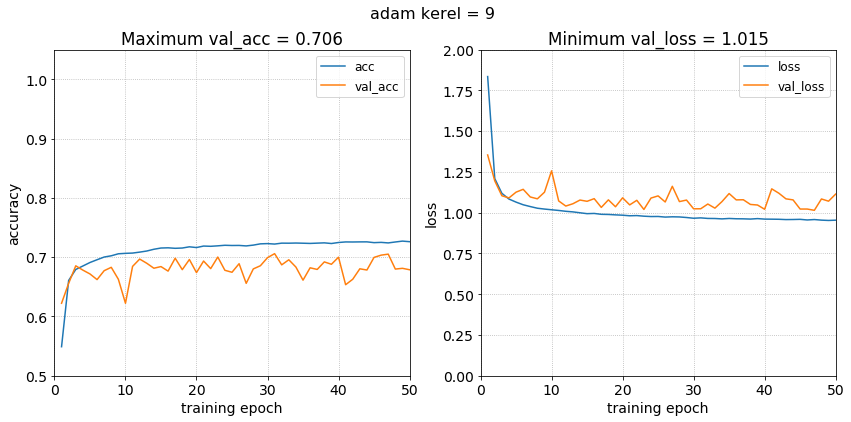

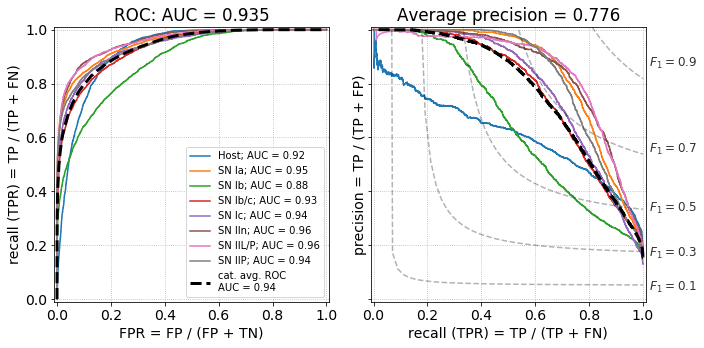

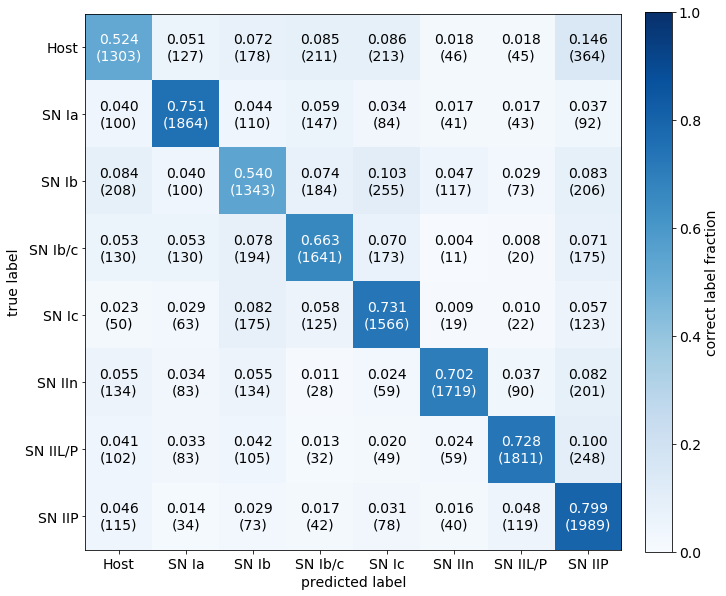

In [29]:
optimizer('adam',9,'adam kerel = 9')

Train on 58492 samples, validate on 19498 samples
Epoch 1/50
58492/58492 [==============================] - 10s 166us/sample - loss: 2.9787 - acc: 0.3993 - val_loss: 2.5929 - val_acc: 0.5413
Epoch 2/50
58492/58492 [==============================] - 9s 154us/sample - loss: 2.4044 - acc: 0.5885 - val_loss: 2.2425 - val_acc: 0.6314
Epoch 3/50
58492/58492 [==============================] - 9s 154us/sample - loss: 2.1500 - acc: 0.6398 - val_loss: 2.0520 - val_acc: 0.6552
Epoch 4/50
58492/58492 [==============================] - 9s 154us/sample - loss: 1.9790 - acc: 0.6607 - val_loss: 1.9012 - val_acc: 0.6719
Epoch 5/50
58492/58492 [==============================] - 9s 154us/sample - loss: 1.8397 - acc: 0.6775 - val_loss: 1.8461 - val_acc: 0.6602
Epoch 6/50
58492/58492 [==============================] - 9s 154us/sample - loss: 1.7298 - acc: 0.6847 - val_loss: 1.7079 - val_acc: 0.6745
Epoch 7/50
58492/58492 [==============================] - 9s 154us/sample - loss: 1.6294 - acc: 0.6924 - val_

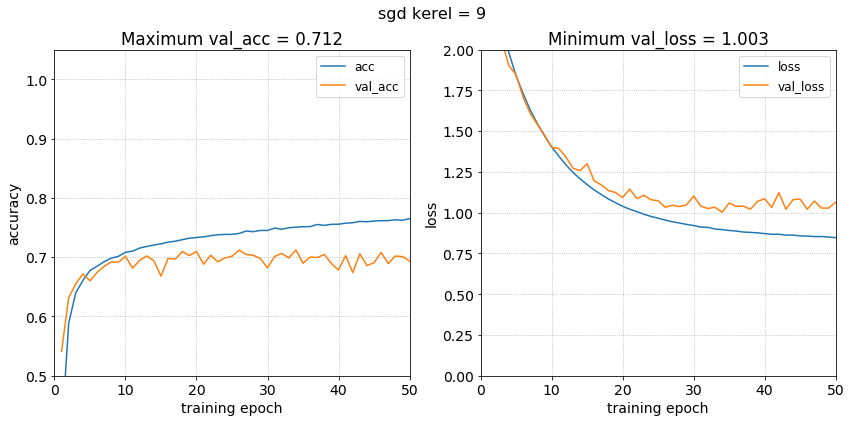

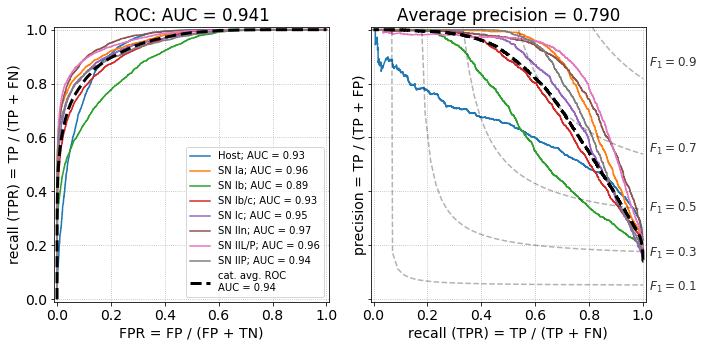

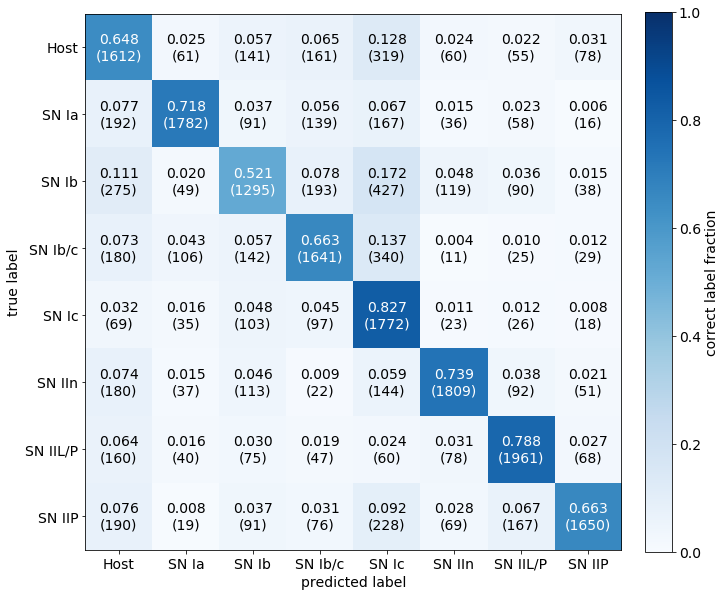

In [30]:
optimizer('sgd',9,'sgd kerel = 9')

Train on 58492 samples, validate on 19498 samples
Epoch 1/50
58492/58492 [==============================] - 11s 190us/sample - loss: 2.6749 - acc: 0.4133 - val_loss: 2.0771 - val_acc: 0.5705
Epoch 2/50
58492/58492 [==============================] - 10s 174us/sample - loss: 1.8370 - acc: 0.6077 - val_loss: 1.6537 - val_acc: 0.6384
Epoch 3/50
58492/58492 [==============================] - 10s 175us/sample - loss: 1.5303 - acc: 0.6513 - val_loss: 1.4437 - val_acc: 0.6606
Epoch 4/50
58492/58492 [==============================] - 10s 174us/sample - loss: 1.3612 - acc: 0.6713 - val_loss: 1.3108 - val_acc: 0.6748
Epoch 5/50
58492/58492 [==============================] - 10s 174us/sample - loss: 1.2516 - acc: 0.6839 - val_loss: 1.2459 - val_acc: 0.6758
Epoch 6/50
58492/58492 [==============================] - 10s 174us/sample - loss: 1.1769 - acc: 0.6932 - val_loss: 1.1994 - val_acc: 0.6815
Epoch 7/50
58492/58492 [==============================] - 10s 174us/sample - loss: 1.1254 - acc: 0.7008 

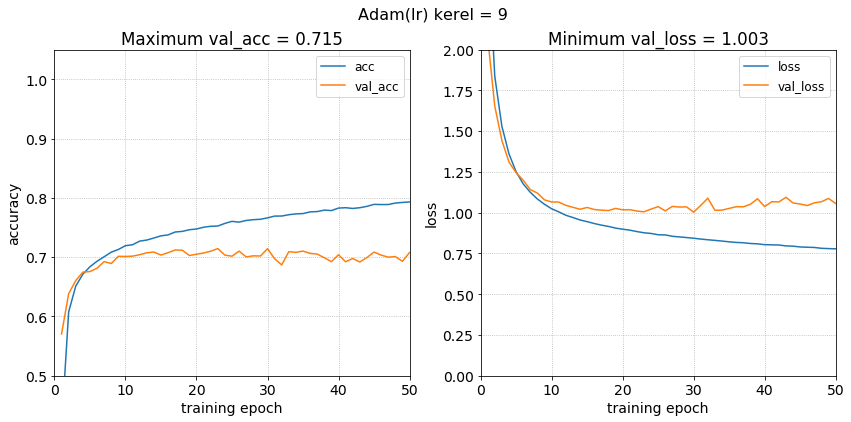

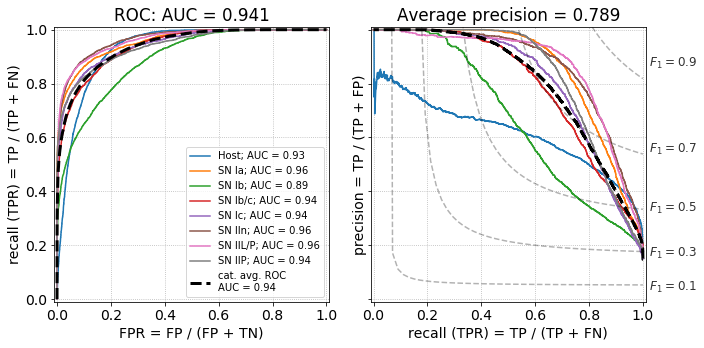

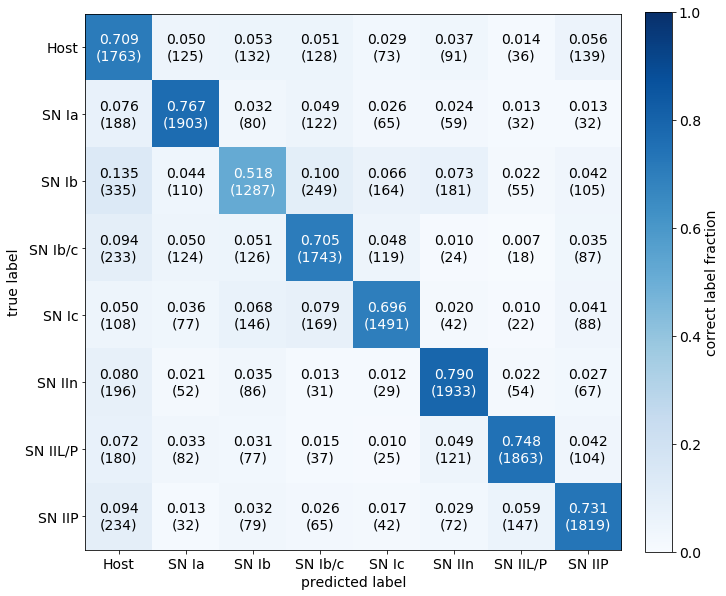

In [34]:
optimizer(Adam(lr=0.0002), 9, 'Adam(lr) kerel = 9')

Train on 58492 samples, validate on 19498 samples
Epoch 1/50
58492/58492 [==============================] - 11s 190us/sample - loss: 1.6747 - acc: 0.5380 - val_loss: 1.2816 - val_acc: 0.6176
Epoch 2/50
58492/58492 [==============================] - 10s 172us/sample - loss: 1.2472 - acc: 0.6331 - val_loss: 1.3185 - val_acc: 0.6017
Epoch 3/50
58492/58492 [==============================] - 10s 172us/sample - loss: 1.2005 - acc: 0.6475 - val_loss: 1.2791 - val_acc: 0.6271
Epoch 4/50
58492/58492 [==============================] - 10s 172us/sample - loss: 1.1788 - acc: 0.6559 - val_loss: 1.3051 - val_acc: 0.6070
Epoch 5/50
58492/58492 [==============================] - 10s 172us/sample - loss: 1.1630 - acc: 0.6623 - val_loss: 1.2816 - val_acc: 0.6121
Epoch 6/50
58492/58492 [==============================] - 10s 173us/sample - loss: 1.1533 - acc: 0.6654 - val_loss: 1.2067 - val_acc: 0.6420
Epoch 7/50
58492/58492 [==============================] - 10s 172us/sample - loss: 1.1419 - acc: 0.6680 

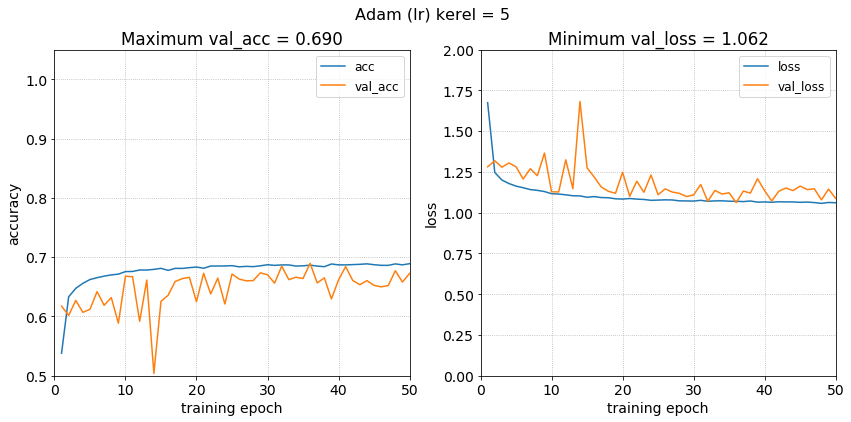

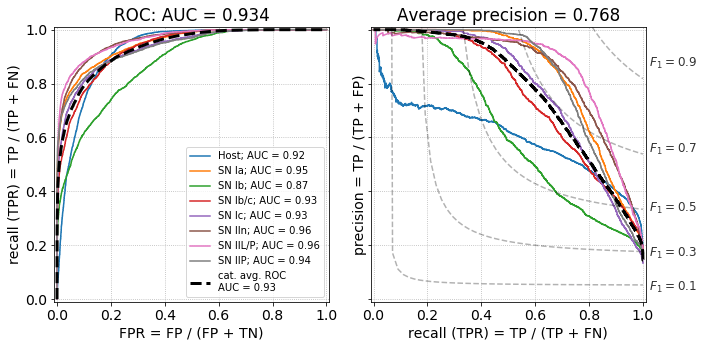

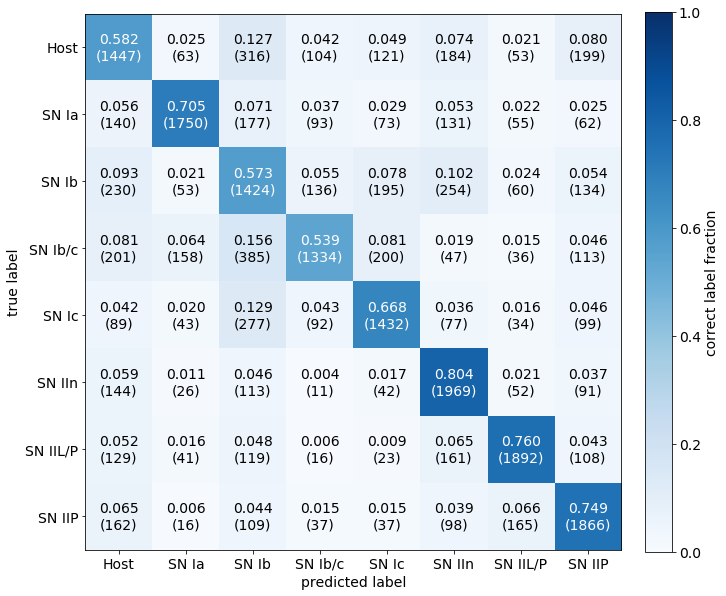

In [35]:
optimizer(Adam(lr=0.002), 5, 'Adam (lr) kerel = 5')

Train on 58492 samples, validate on 19498 samples
Epoch 1/50
58492/58492 [==============================] - 11s 195us/sample - loss: 2.1631 - acc: 0.5058 - val_loss: 1.5737 - val_acc: 0.6171
Epoch 2/50
58492/58492 [==============================] - 10s 176us/sample - loss: 1.3827 - acc: 0.6503 - val_loss: 1.2822 - val_acc: 0.6566
Epoch 3/50
58492/58492 [==============================] - 10s 178us/sample - loss: 1.1906 - acc: 0.6754 - val_loss: 1.1770 - val_acc: 0.6641
Epoch 4/50
58492/58492 [==============================] - 10s 176us/sample - loss: 1.1054 - acc: 0.6878 - val_loss: 1.0882 - val_acc: 0.6917
Epoch 5/50
58492/58492 [==============================] - 10s 176us/sample - loss: 1.0566 - acc: 0.6982 - val_loss: 1.0617 - val_acc: 0.6935
Epoch 6/50
58492/58492 [==============================] - 10s 176us/sample - loss: 1.0281 - acc: 0.7040 - val_loss: 1.0617 - val_acc: 0.6865
Epoch 7/50
58492/58492 [==============================] - 10s 176us/sample - loss: 1.0080 - acc: 0.7097 

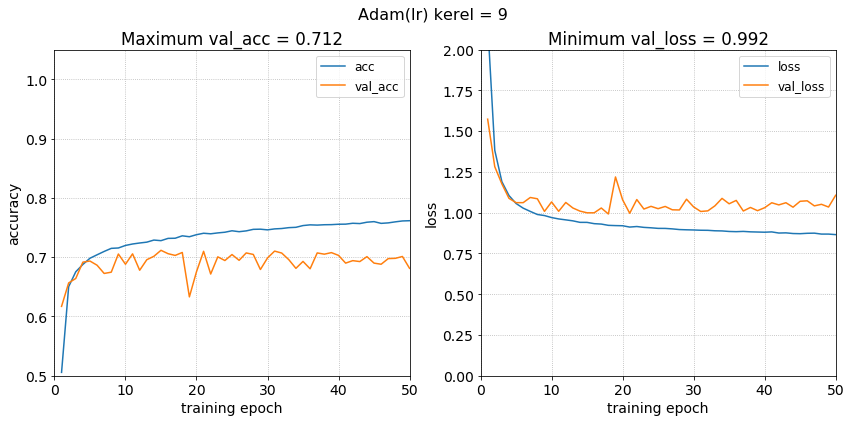

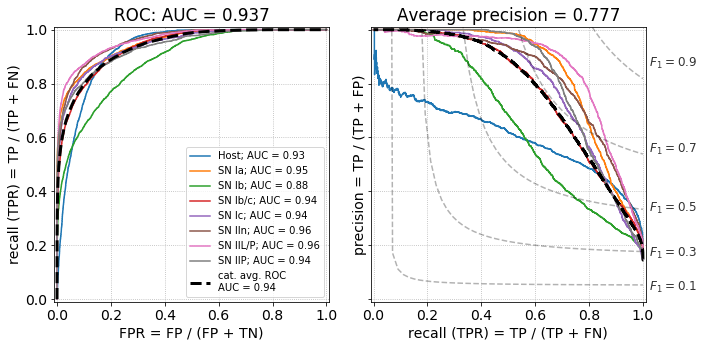

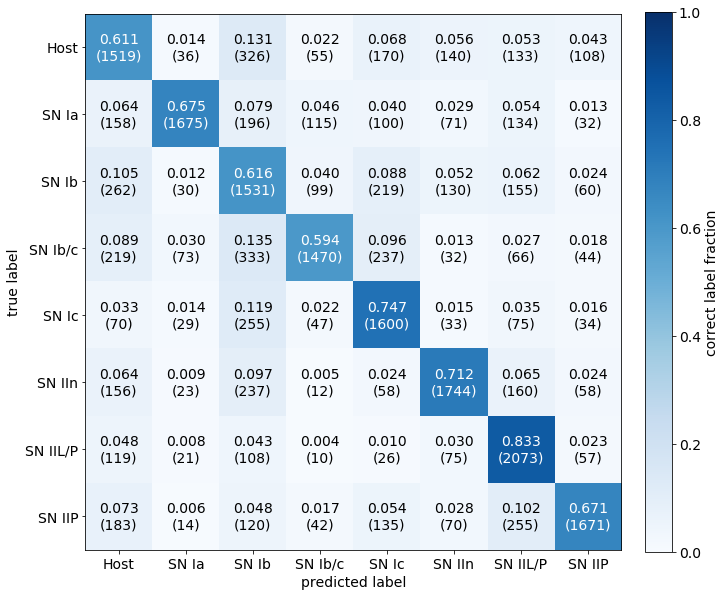

In [36]:
optimizer(Adam(lr=0.0005), 9, 'Adam(lr) kerel = 9')

Train on 58492 samples, validate on 19498 samples
Epoch 1/50
58492/58492 [==============================] - 11s 194us/sample - loss: 2.2144 - acc: 0.4902 - val_loss: 1.6757 - val_acc: 0.5824
Epoch 2/50
58492/58492 [==============================] - 10s 172us/sample - loss: 1.4607 - acc: 0.6297 - val_loss: 1.3305 - val_acc: 0.6489
Epoch 3/50
58492/58492 [==============================] - 10s 174us/sample - loss: 1.2543 - acc: 0.6596 - val_loss: 1.2279 - val_acc: 0.6622
Epoch 4/50
58492/58492 [==============================] - 10s 173us/sample - loss: 1.1644 - acc: 0.6726 - val_loss: 1.1427 - val_acc: 0.6732
Epoch 5/50
58492/58492 [==============================] - 10s 173us/sample - loss: 1.1097 - acc: 0.6840 - val_loss: 1.1120 - val_acc: 0.6806
Epoch 6/50
58492/58492 [==============================] - 10s 173us/sample - loss: 1.0784 - acc: 0.6905 - val_loss: 1.1414 - val_acc: 0.6662
Epoch 7/50
58492/58492 [==============================] - 10s 173us/sample - loss: 1.0588 - acc: 0.6955 

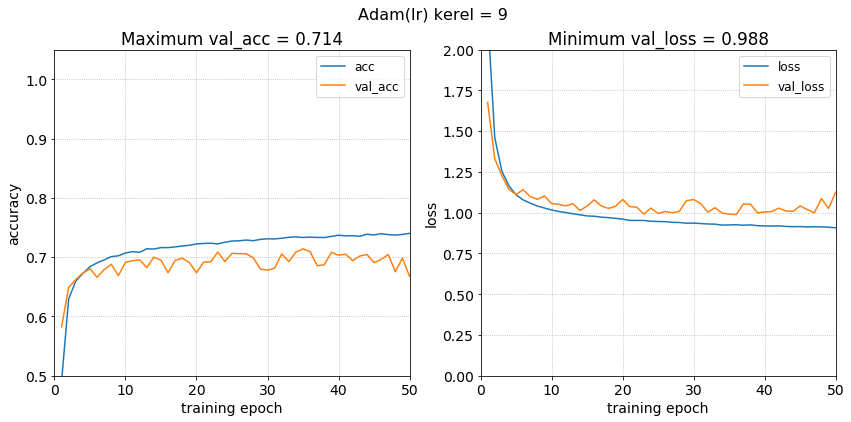

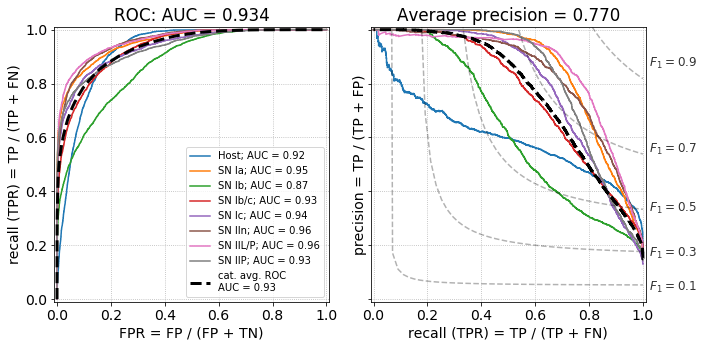

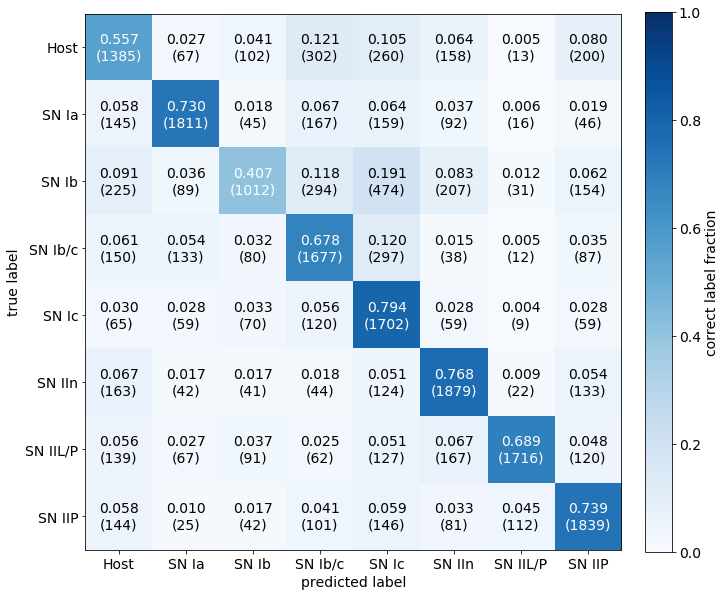

In [37]:
optimizer(Adam(lr=0.0005), 5, 'Adam(lr) kerel = 9')